In [ ]:
# Cell 1 – Imports & User Settings

from pathlib import Path                                   # file paths
import numpy as np                                          # arrays and math
import matplotlib.pyplot as plt                             # plotting
from scipy.optimize import curve_fit                        # non-linear least squares
from scipy.signal import find_peaks, savgol_filter          # peak finding + smoothing

BASE_DIR = Path("C:")  # base data folder
fg_file = BASE_DIR / "HPGe/Pitchblende.Spe"             # foreground file path
bg_file = BASE_DIR / "HPGe/background.Spe"  # background file path

DATA_START_LINE = 12                                        # first data line (0-based) in .Spe
N_CHANNELS = 16000                                            # number of channels to read

PEAK_MODE = "single"                                        # "single" or "double" peak fit
SINGLE_SELECT = "rightmost"                                 # for "single": choose "rightmost" or "strongest"

YSCALE = "linear"                                           # y-axis scale ("linear" or "log")
X_FRACTION = 1.0                                            # fraction of x-range to show (1.0 = full)
BG_SCALE = 1.0                                              # background live-time scaling
LEGEND_MODE = "auto_corner"                                 # "auto_corner" or "outside_top"

m_keV_per_ch = 0.096257                                    # slope (keV/channel)
c_keV = 14.235                                           # intercept (keV)
m_keV_per_ch_e = 0.039797                                   # slope uncertainty (keV/channel)
c_keV_e = 10.666                                            # intercept uncertainty (keV)
calib_R2 = 0.99958                                          # R^2 of calibration fit

SMOOTH_WIN = max(7, (int(0.03 * N_CHANNELS) // 2) * 2 + 1)  # Savitzky–Golay window (odd)
SMOOTH_POLY = 2                                             # Savitzky–Golay polynomial order
PROM_FRAC = 0.02                                            # prominence threshold (fraction of max)
MIN_WIDTH_CH = max(8, int(0.02 * N_CHANNELS))               # minimum peak width (channels)
MIN_SEP_CH = max(18, int(0.05 * N_CHANNELS))                # minimum peak separation (channels)
TOP_K = 12                                                  # number of candidates to keep

ZOOM_THR_FRAC = 0.01                                        # fraction for “relevant” bins
ZOOM_MARGIN_CH = 10                                         # extra channels to the right in zoom


In [2]:
# Cell 2 – Helper Functions (Reading, Fitting, Legend Placement)

def read_spe_counts(path: Path, n_channels: int, start_line: int) -> np.ndarray:
    lines = Path(path).read_text().splitlines()             # read file as lines
    block = lines[start_line:start_line + n_channels]        # slice the counts block
    if len(block) != n_channels:                             # check length
        raise ValueError(f"{path} lacks {n_channels} lines at {start_line}.")  # fail if mismatch
    counts = [int(row.strip().split()[0]) for row in block]  # parse first token as int
    return np.asarray(counts, dtype=int)                     # return as int array

def poisson_sigma(y: np.ndarray) -> np.ndarray:
    s = np.sqrt(np.clip(y, 0, None))                        # sqrt(counts) with non-negative clip
    s[s == 0] = 1.0                                         # floor zero uncertainty at 1
    return s                                                # return uncertainties

def sanitize_xyerr(x, y, yerr, min_err=1.0):
    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(yerr)  # finite mask
    x, y, yerr = x[m], y[m], yerr[m]                         # keep finite values
    yerr = np.where(yerr <= 0, min_err, yerr)                # floor non-positive errors
    return x, y, yerr                                        # return cleaned arrays

def fit_with_fallback(func, x, y, yerr, p0, bounds):
    x, y, yerr = sanitize_xyerr(x, y, yerr)                 # clean inputs
    try:                                                     # try weighted fit
        popt, pcov = curve_fit(func, x, y, p0=p0, sigma=yerr,
                               absolute_sigma=True, bounds=bounds, maxfev=20000)  # weighted
    except Exception:                                        # on failure
        popt, pcov = curve_fit(func, x, y, p0=p0, bounds=bounds, maxfev=20000)    # unweighted fallback
    return popt, pcov                                        # best-fit params and covariance

def gaus_plus_bg(x, A, x0, sigma, c0, c1, c2):
    return A * np.exp(-(x - x0) ** 2 / (2.0 * sigma ** 2)) + (c0 + c1 * x + c2 * x * x)  # Gaussian + quadratic bg

def gaus2_plus_bg(x, A1, x1, s1, A2, x2, s2, c0, c1, c2):
    g1 = A1 * np.exp(-(x - x1) ** 2 / (2 * s1 ** 2))        # first Gaussian
    g2 = A2 * np.exp(-(x - x2) ** 2 / (2 * s2 ** 2))        # second Gaussian
    return g1 + g2 + (c0 + c1 * x + c2 * x * x)             # sum + quadratic bg

def legend_outside_top():
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.12), ncol=3, frameon=True)  # legend above axes

def legend_auto_corner(x_axis, xmin, xmax, y_series):
    in_view = (x_axis >= xmin) & (x_axis <= xmax)            # mask points in view
    xv = x_axis[in_view]                                     # x in view
    yv = np.maximum(y_series[in_view], 0.0)                  # y in view (non-negative)
    if yv.size == 0 or yv.max() <= 0:                        # nothing useful
        plt.legend(loc="upper right", framealpha=0.85)       # safe default
        return                                               # stop
    peak_x = xv[np.argmax(yv)]                               # strongest visible peak x
    frac = (peak_x - xv.min()) / (xv.max() - xv.min() + 1e-12)  # normalized position
    loc = "upper left" if frac > 0.55 else "upper right"     # choose opposite corner
    plt.legend(loc=loc, framealpha=0.85)                     # draw legend


In [3]:
# Cell 3 – Load Data & Build Background-Subtracted Spectrum

fg = read_spe_counts(fg_file, N_CHANNELS, DATA_START_LINE)   # read foreground counts
bg = read_spe_counts(bg_file, N_CHANNELS, DATA_START_LINE)   # read background counts
bg_scaled = (BG_SCALE * bg).astype(float)                    # scale background
sub = fg.astype(float) - bg_scaled                           # subtract background
ch = np.arange(1, N_CHANNELS + 1)                            # channel axis (1-based)
fg_err = poisson_sigma(fg)                                   # foreground uncertainties
bg_err = poisson_sigma(bg)                                   # background uncertainties
sub_err = poisson_sigma(fg + (BG_SCALE ** 2) * bg)           # conservative diff uncertainty


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/joshd/OneDrive - University of Glasgow/Mac Book Documents/University/Glasgow/Diss/Data/HPGe/Pitchblende.Spe'

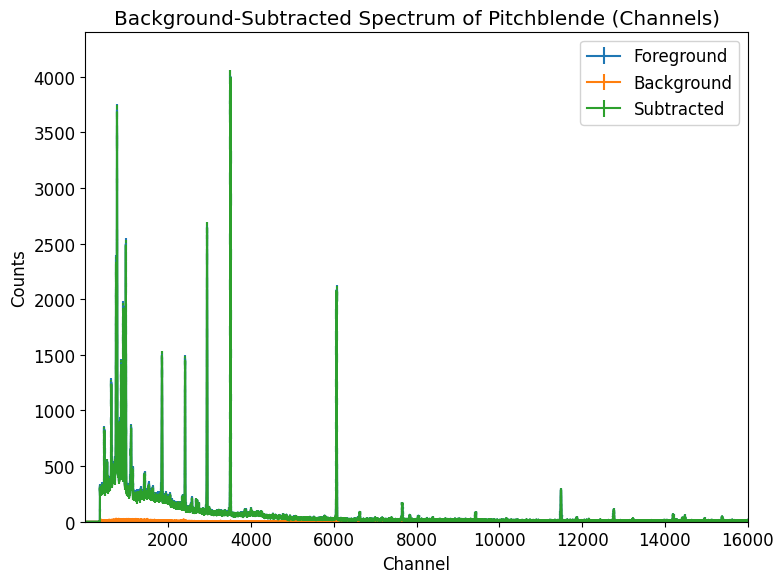

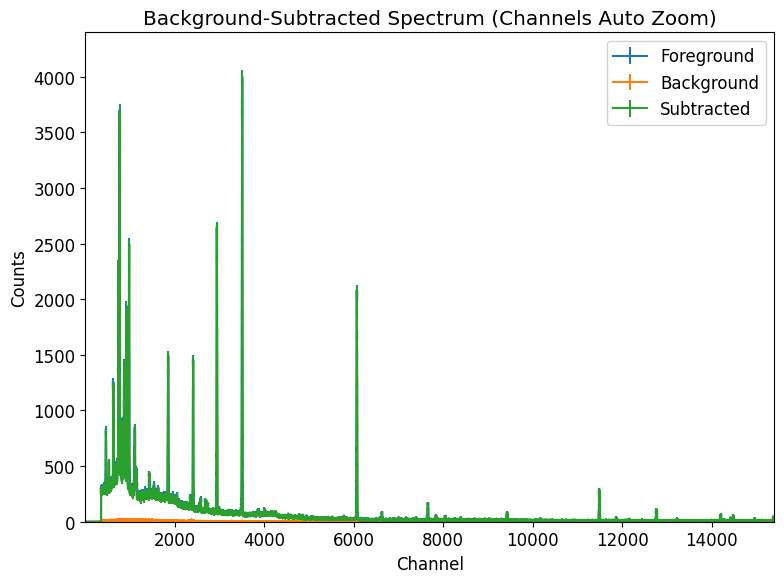

In [ ]:
# Cell 4 – Spectrum in Channel Space (Overview + Auto-Zoom)

plt.rcParams.update({"font.family": "DejaVu Sans", "font.size": 12, "figure.figsize": (8, 6)})  # style

# Overview
xmax = int(X_FRACTION * ch.max())                           # right x-limit from fraction
yclip = np.clip(sub, 0.1, None) if YSCALE == "log" else sub # clip for log scale if used
ymax = 1.1 * max(fg.max(), yclip.max())                     # y-limit with headroom
plt.yscale(YSCALE)                                          # y scale
plt.axis([ch.min(), xmax, 0.1 if YSCALE == "log" else 0.0, ymax])  # axes
plt.xlabel("Channel")                                        # label
plt.ylabel("Counts")                                         # label
plt.title(f"Background-Subtracted Spectrum of {fg_file.stem} (Channels)")  # title
plt.errorbar(ch, fg, yerr=fg_err, label="Foreground")        # plot
plt.errorbar(ch, bg, yerr=bg_err, label="Background")        # plot
plt.errorbar(ch, yclip, yerr=sub_err, label="Subtracted")    # plot
legend_outside_top() if LEGEND_MODE == "outside_top" else legend_auto_corner(ch, ch.min(), xmax, yclip)  # legend
plt.tight_layout()                                           # layout
plt.show()                                                   # show

# Auto-zoom
sub_pos = np.maximum(sub, 0.0)                               # non-negative for threshold
thr = max(1.0, ZOOM_THR_FRAC * float(sub_pos.max()))         # dynamic threshold
active = sub_pos > thr                                       # active bins
last_active = int(np.where(active)[0].max()) + 1 if np.any(active) else xmax  # rightmost active
x_hi_zoom = min(N_CHANNELS, last_active + ZOOM_MARGIN_CH)    # margin to the right
ymax_zoom = 1.1 * max(fg[:x_hi_zoom].max(), yclip[:x_hi_zoom].max())         # zoom y-limit
plt.yscale(YSCALE)                                           # y scale
plt.axis([ch.min(), x_hi_zoom, 0.1 if YSCALE == "log" else 0.0, ymax_zoom])  # axes
plt.xlabel("Channel")                                        # label
plt.ylabel("Counts")                                         # label
plt.title("Background-Subtracted Spectrum (Channels Auto Zoom)")             # title
plt.errorbar(ch, fg, yerr=fg_err, label="Foreground")        # plot
plt.errorbar(ch, bg, yerr=bg_err, label="Background")        # plot
plt.errorbar(ch, yclip, yerr=sub_err, label="Subtracted")    # plot
legend_outside_top() if LEGEND_MODE == "outside_top" else legend_auto_corner(ch, ch.min(), x_hi_zoom, yclip)  # legend
plt.tight_layout()                                           # layout
plt.show()                                                   # show


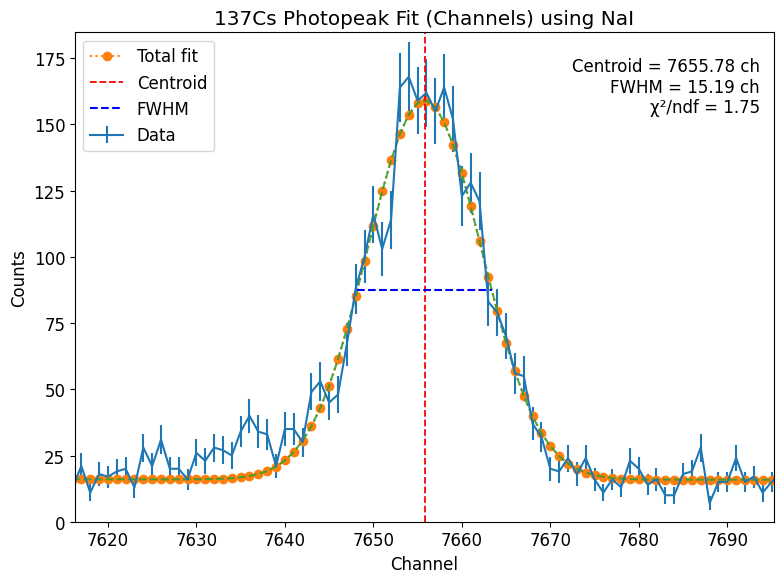

Centroid (ch): 7655.78 ± 0.17
FWHM (ch):     15.19 ± 0.34
chi2/ndf: 1.75 (ndf=1791)


In [ ]:
# Cell 5 – Photopeak Gaussian Fit (Channels) + Centroid & Horizontal FWHM

# Smooth and find candidate peaks
spec_smooth = savgol_filter(np.maximum(sub, 0.0), SMOOTH_WIN, SMOOTH_POLY)  # smooth spectrum
prom = max(1.0, PROM_FRAC * float(spec_smooth.max()))                        # absolute prominence
pk_idx, pk_props = find_peaks(spec_smooth, prominence=prom,
                              width=(MIN_WIDTH_CH, None), distance=MIN_SEP_CH)  # peak find

# Fallback if none found
if pk_idx.size == 0:                                                         # no peaks
    pk_idx = np.array([int(np.argmax(spec_smooth))])                         # use global max
    pk_props = {"widths": np.array([max(MIN_WIDTH_CH, 8.0)]),
                "prominences": np.array([spec_smooth.max()])}               # minimal props

# Rank and pick peaks
score = pk_props["prominences"] * pk_props["widths"]                         # strength score
order = np.argsort(score)[::-1]                                              # strongest first
pk_idx_sorted = pk_idx[order][:TOP_K]                                        # top K indices
widths_sorted = pk_props["widths"][order][:TOP_K]                            # matching widths
if PEAK_MODE.lower() == "single":                                            # single mode
    if pk_idx_sorted.size > 1 and SINGLE_SELECT == "rightmost":              # rightmost rule
        pick = int(np.max(pk_idx_sorted))                                    # choose rightmost
        w0 = float(widths_sorted[np.argmax(pk_idx_sorted)])                  # width near it
    else:                                                                    # otherwise strongest
        pick = int(pk_idx_sorted[0])                                         # choose strongest
        w0 = float(widths_sorted[0])                                         # width near it
    peaks = np.array([pick], dtype=int)                                      # one peak
else:                                                                        # double mode
    if pk_idx_sorted.size < 2:                                               # only one candidate
        pick = int(pk_idx_sorted[0])                                         # strongest
        peaks = np.array([max(1, pick - MIN_SEP_CH // 2),
                           min(N_CHANNELS, pick + MIN_SEP_CH // 2)], dtype=int)  # synthesize pair
        w0 = float(widths_sorted[0])                                         # width near strongest
    else:                                                                    # have two+
        right_two = np.sort(pk_idx_sorted)[-2:]                              # two rightmost
        peaks = right_two.astype(int)                                        # indices
        idx_map = {int(pk): i for i, pk in enumerate(pk_idx_sorted)}         # map to width
        w_left = float(widths_sorted[idx_map.get(int(peaks[0]), 0)])         # left width
        w_right = float(widths_sorted[idx_map.get(int(peaks[1]), 0)])        # right width
        w0 = max(w_left, w_right)                                            # safe window width

# Define fit window
def _window(peaks_arr, half_span_fwhm=2.0):                                  # helper
    fwhm = np.array([max(6.0, float(w0))], dtype=float)                      # FWHM guess
    margin = int(np.ceil(half_span_fwhm * fwhm.max()))                       # margin in channels
    lo = max(1, int(np.min(peaks_arr)) - margin)                             # left bound
    hi = min(N_CHANNELS, int(np.max(peaks_arr)) + margin)                    # right bound
    return lo, hi                                                            # window bounds

lo, hi = _window(peaks)                                                      # window
mask = (ch >= lo) & (ch <= hi)                                               # mask inside window
x = ch[mask].astype(float)                                                   # x data (channels)
y = sub[mask].astype(float)                                                  # y data (counts)
yerr = sub_err[mask].astype(float)                                           # y errors
x, y, yerr = sanitize_xyerr(x, y, yerr)                                      # clean arrays

# Fit single or double Gaussian + background
if PEAK_MODE.lower() == "single":                                            # single model
    A0 = float(np.max(y))                                                    # amp guess
    x0 = float(x[np.argmax(y)])                                              # centroid guess
    s0 = max(1.0, w0 / 2.355)                                                # sigma guess
    p0 = [A0, x0, s0, 0.0, 0.0, 0.0]                                         # initial params
    bounds = ([0.0, lo, 1e-6, -np.inf, -np.inf, -np.inf],                    # lower bounds
              [np.inf, hi, np.inf, np.inf, np.inf, np.inf])                  # upper bounds
    popt, pcov = fit_with_fallback(gaus_plus_bg, x, y, yerr, p0, bounds)     # fit
    perr = np.sqrt(np.diag(pcov))                                            # errors
    A, x0, sigma, c0, c1, c2 = popt                                          # params
    A_e, x0_e, sigma_e = perr[0], perr[1], perr[2]                           # param errors
    FWHM = 2.355 * sigma                                                     # FWHM (ch)
    FWHM_e = 2.355 * sigma_e                                                 # FWHM error (ch)
    area = np.sqrt(2 * np.pi) * A * sigma                                    # Gaussian area
    area_e = area * np.sqrt((A_e / max(A, 1e-12))**2 + (sigma_e / max(sigma, 1e-12))**2)  # area error
    y_fit = gaus_plus_bg(x, *popt)                                           # total model
    gauss_only = A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))               # Gaussian comp
    comps = [gauss_only]                                                     # list of comps
    x0s = np.array([x0]); x0s_e = np.array([x0_e])                           # centroids
    FWHMs = np.array([FWHM]); FWHMs_e = np.array([FWHM_e])                   # FWHMs
    coeffs = (c0, c1, c2)                                                    # background coeffs
else:                                                                        # double model
    peaks = np.sort(peaks)                                                   # left->right
    w_floor = max(1.0, MIN_WIDTH_CH / 2.355)                                 # sigma floor
    A1_0 = float(spec_smooth[int(peaks[0])])                                 # amp1 guess
    A2_0 = float(spec_smooth[int(peaks[1])])                                 # amp2 guess
    x1_0, x2_0 = float(peaks[0]), float(peaks[1])                            # centroids guess
    s1_0, s2_0 = w_floor, w_floor                                            # sigmas guess
    p0 = [A1_0, x1_0, s1_0, A2_0, x2_0, s2_0, 0.0, 0.0, 0.0]                 # initial params
    s_max = max(5.0, (hi - lo) / 2.0)                                        # sigma cap
    bounds = ([0.0, lo, 1e-6, 0.0, lo, 1e-6, -np.inf, -np.inf, -np.inf],     # lower bounds
              [np.inf, hi, s_max, np.inf, hi, s_max, np.inf, np.inf, np.inf])# upper bounds
    popt, pcov = fit_with_fallback(gaus2_plus_bg, x, y, yerr, p0, bounds)    # fit
    perr = np.sqrt(np.diag(pcov))                                            # errors
    A1, x1, s1, A2, x2, s2, c0, c1, c2 = popt                                # params
    A1_e, x1_e, s1_e, A2_e, x2_e, s2_e = perr[0], perr[1], perr[2], perr[3], perr[4], perr[5]  # errors
    FWHM1, FWHM2 = 2.355 * s1, 2.355 * s2                                    # FWHMs (ch)
    FWHM1_e, FWHM2_e = 2.355 * s1_e, 2.355 * s2_e                            # FWHM errors (ch)
    y_fit = gaus2_plus_bg(x, *popt)                                          # total model
    ga1 = A1 * np.exp(-(x - x1) ** 2 / (2 * s1 ** 2))                        # Gaussian 1
    ga2 = A2 * np.exp(-(x - x2) ** 2 / (2 * s2 ** 2))                        # Gaussian 2
    comps = [ga1, ga2]                                                       # list of comps
    x0s = np.array([x1, x2]); x0s_e = np.array([x1_e, x2_e])                 # centroids
    FWHMs = np.array([FWHM1, FWHM2]); FWHMs_e = np.array([FWHM1_e, FWHM2_e]) # FWHMs
    coeffs = (c0, c1, c2)                                                    # background coeffs

# Goodness of fit
chi2 = np.sum(((y - y_fit) / yerr) ** 2)                                     # chi-square
ndf = len(y) - (6 if PEAK_MODE.lower() == "single" else 9)                   # degrees of freedom
chi2_ndf = chi2 / max(ndf, 1)                                                # reduced chi-square

# Plot fit with centroid and FWHM guides (now with separate colors + legend labels)
plt.yscale(YSCALE)                                                           # set y-axis scale (linear or log)
title = "137Cs Photopeak Fit (Channels) using NaI" if PEAK_MODE.lower() == "single" \
        else "Double-Photopeak Fit (Channels)"                               # set figure title depending on single/double fit
# choose x-span to focus around peak(s)
if PEAK_MODE.lower() == "single":                                            # single-peak window
    center = x0s[0]                                                          # centroid channel
    span = 2.6 * FWHMs[0]                                                    # span ~2.6×FWHM around centroid
else:                                                                        # double-peak window
    center = 0.5 * (x0s.min() + x0s.max())                                   # midpoint between peaks
    span = 2.6 * (FWHMs.max() + (x0s.max() - x0s.min()) / 2.0)               # wider span to include both peaks
x_lo = max(x.min(), center - span)                                           # left x-axis limit
x_hi = min(x.max(), center + span)                                           # right x-axis limit
ymax_local = 1.1 * max(y.max(), y_fit.max())                                 # y-axis maximum with 10% headroom
plt.axis([x_lo, x_hi, 0.0 if YSCALE == "linear" else 0.1, ymax_local])       # apply axis limits
plt.xlabel("Channel")                                                        # label x-axis
plt.ylabel("Counts")                                                         # label y-axis
plt.title(title)                                                             # apply title

plt.errorbar(x, y, yerr=yerr, label="Data")                                  # plot measured data with error bars
plt.plot(x, y_fit, "o:", label="Total fit")                                  # plot total fitted curve
c0, c1, c2 = coeffs                                                          # unpack quadratic background coeffs
for i, yc in enumerate(comps, 1):                                            # loop through Gaussian component(s)
    plt.plot(x, yc + (c0 + c1 * x + c2 * x * x), "--", alpha=0.85,          )# plot Gaussian+background component

# draw centroid (vertical) and FWHM (horizontal) lines with different colors
for i, (xc, fwhm, comp) in enumerate(zip(x0s, FWHMs, comps), 1):             # loop over peaks
    y_bg_xc = c0 + c1 * xc + c2 * xc * xc                                    # background level at centroid
    A_at_xc = float(np.max(comp))                                            # peak amplitude (no bg)
    y_half = y_bg_xc + 0.5 * A_at_xc                                         # half-maximum level including bg

    # draw centroid line (red, dashed) — only label once in legend
    plt.axvline(xc, color="red", linestyle="--", linewidth=1.3,
                label="Centroid" if i == 1 else None)

    # draw FWHM horizontal line (blue, dashed) — only label once in legend
    left = xc - 0.5 * fwhm                                                   # left FWHM x-position
    right = xc + 0.5 * fwhm                                                  # right FWHM x-position
    plt.hlines(y_half, left, right, colors="blue", linestyles="--", linewidth=1.5,
               label="FWHM" if i == 1 else None)

# small annotation box with text (kept out of main data region)
ax = plt.gca()                                                               # get current axes
txt_lines = []                                                               # prepare list of lines for box
if PEAK_MODE.lower() == "single":                                            # single peak text
    txt_lines.append(f"Centroid = {x0s[0]:.2f} ch")                          # centroid value
    txt_lines.append(f"FWHM = {FWHMs[0]:.2f} ch")                            # FWHM value
else:                                                                        # double peak text
    for i in range(len(x0s)):
        txt_lines.append(f"P{i+1} Centroid = {x0s[i]:.2f} ch")               # centroid for each peak
        txt_lines.append(f"P{i+1} FWHM = {FWHMs[i]:.2f} ch")                 # FWHM for each peak
txt_lines.append(f"χ²/ndf = {chi2_ndf:.2f}")                                 # reduced chi-square metric
ax.text(0.98, 0.95, "\n".join(txt_lines), transform=ax.transAxes,            # add text box in top-right
        ha="right", va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, linewidth=0.0))  # white background, semi-transparent

plt.legend(loc="upper left")                                                # show legend (includes new centroid/FWHM)
plt.tight_layout()                                                           # adjust layout for figure
plt.show()                                                                   # render plot

# print fit metrics (channels)
if PEAK_MODE.lower() == "single":                                            # console output (channels)
    print(f"Centroid (ch): {x0s[0]:.2f} ± {x0s_e[0]:.2f}")                   # centroid
    print(f"FWHM (ch):     {FWHMs[0]:.2f} ± {FWHMs_e[0]:.2f}")               # FWHM
else:                                                                         # double case
    for i in range(2):                                                        # each peak
        print(f"[Peak {i+1}] Centroid (ch): {x0s[i]:.2f} ± {x0s_e[i]:.2f}")  # centroid
        print(f"[Peak {i+1}] FWHM (ch):     {FWHMs[i]:.2f} ± {FWHMs_e[i]:.2f}")  # FWHM
print(f"chi2/ndf: {chi2_ndf:.2f} (ndf={ndf})")                                # goodness of fit
